<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/Wavelet1DDenoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of wavelet denoising 1D
 use a simple hard thresholding technics
 compare with a simple hard cut on FFT spectrum

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

In [3]:
from pywt import swt,iswt,threshold  # wavelet lib.

In [4]:
#signal
def f(x):
    return (5+np.piecewise(x,[x>=0, x>=0.05, x>=0.2,x>=0.55,x>=0.75, x>=0.9],
                [0, -30.,
                 lambda x: 10-10*np.sin((8*x + 0.8)*np.pi),
                 lambda x: 100-5*np.exp(4*x),
                 lambda x: -(80-5*np.exp(3*x)),
                 0.]))*2

In [5]:
Ns= 2**11
xvals = np.linspace(0.,1.,Ns)
signal = f(xvals)

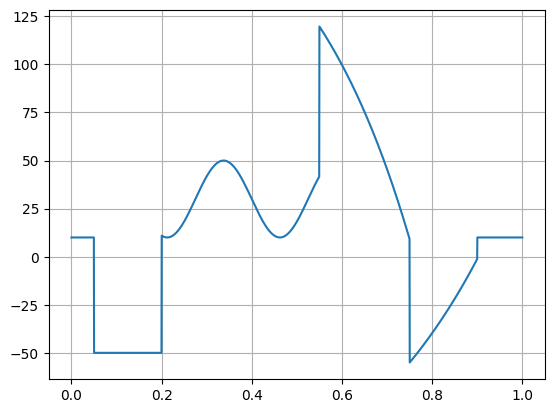

In [6]:
plot(xvals,signal)
grid()

In [7]:
level=6    # level of decomposition (if None then get maximum depth)
wave="db2" # type of wavelet: db2 aka Daubechies 2  ("db1" is Haar)

In [8]:
coeffs = swt(signal,wave,level=level,trim_approx=True) # use stationnary wavelet decompostion

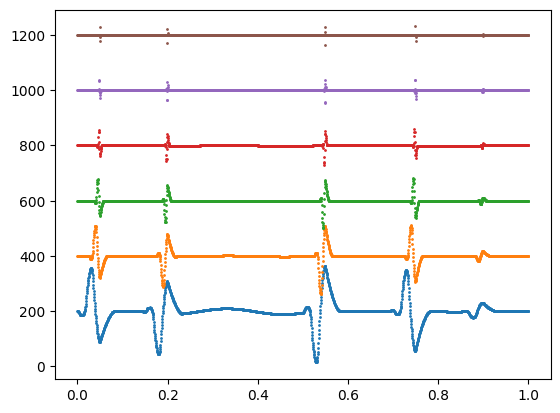

In [9]:
# show details coefficients on the same plot
for i in range(1,len(coeffs)):
    scatter(xvals,i*200 + coeffs[i],s=1)

In [41]:
#noisy observation
sigma = 5
noise = sigma*np.random.normal(size=(Ns,))
obs = signal + noise

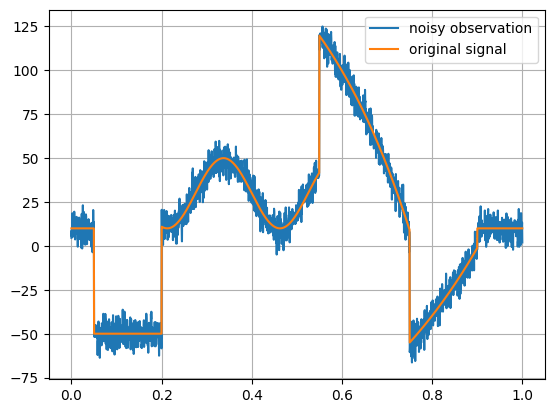

In [42]:
plot(xvals,obs,label="noisy observation")
plot(xvals,signal,label="original signal")
legend()
grid()

In [43]:
# decompsition of noisy observation
coeffs_o = swt(obs,wave,level=level,trim_approx=True)

In [44]:
# Hard threshold denoising
coeffs_o_th = coeffs_o.copy()
Threshold = 5*sigma
for i in range(0,len(coeffs_o)):
    coeffs_o_th[i] = threshold(coeffs_o[i],Threshold,mode='hard',substitute=0)

In [70]:
n= 0
sum = 0
for  i in range(0,len(coeffs_o)):
  n += len(coeffs_o_th[i])
  sum += np.count_nonzero(coeffs_o_th[i])
print('fraction non-zero coeff',sum,n,sum/n)

fraction non-zero coeff 2738 14336 0.19098772321428573


In [45]:
# estimation of denoised signal
hat_signal = iswt(coeffs_o_th,wave)

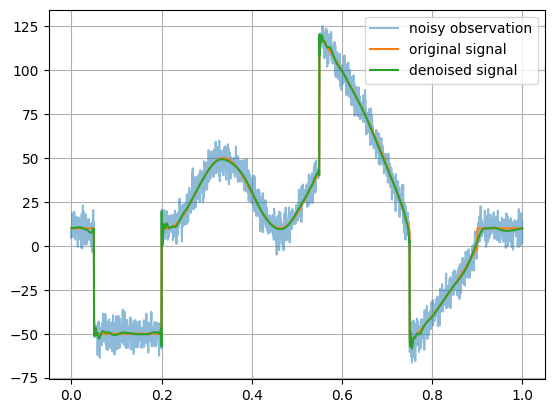

In [46]:
plot(xvals,obs,label="noisy observation",alpha=0.5)
plot(xvals,signal,label="original signal")
plot(xvals,hat_signal, label="denoised signal")
legend()
grid()

In [47]:
#metric to compare x wrt x_refernce
def metric(x,xref):
    return 10*np.log10(np.mean(xref**2)/np.mean((x-xref)**2))

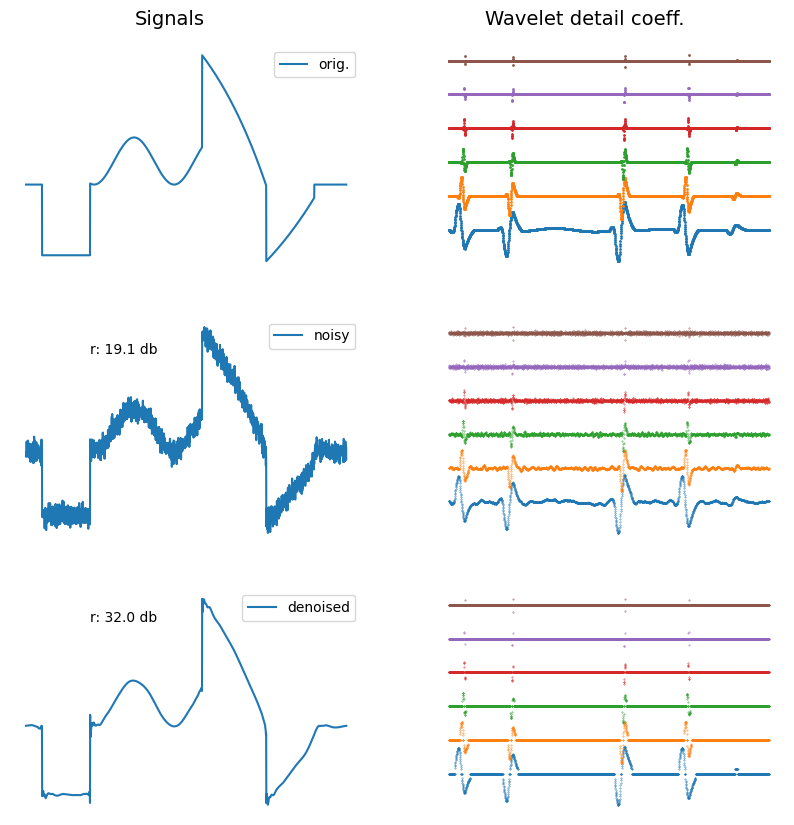

In [48]:
fig,axs=subplots(3,2,figsize=(10,10))
axs[0,0].plot(xvals,signal,label="orig.")
axs[1,0].plot(xvals,obs,label="noisy")
axs[2,0].plot(xvals,hat_signal,label="denoised")
axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()

axs[1,0].text(0.2,100,f"r: {metric(obs,signal):.3} db")
axs[2,0].text(0.2,100,f"r: {metric(hat_signal,signal):.3} db")


for i in range(1,len(coeffs)):
    axs[0,1].scatter(xvals,i*200 + coeffs[i],s=1)
    axs[1,1].scatter(xvals,i*200 + coeffs_o[i],s=0.1)
    axs[2,1].scatter(xvals,i*200 + coeffs_o_th[i],s=0.1)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

fig.text(0.25,0.9,"Signals",fontsize=14);
fig.text(0.6,0.9,"Wavelet detail coeff.",fontsize=14);

In [112]:
from scipy.fft import rfft, irfft, rfftfreq

In [113]:
fft_signal = rfft(signal,norm='forward')
fft_obs =  rfft(obs,norm='forward')
fft_noise =  rfft(noise,norm='forward')

In [114]:
dt = xvals[1]-xvals[0]

In [115]:
freqs = rfftfreq(n=Ns,d=dt)

In [117]:
fft_obs_cut  = fft_obs.copy()
n_cut = 50
print(f"cut at {freqs[n_cut]:.2f} Hz")
fft_obs_cut[n_cut:]=0.

cut at 49.98 Hz


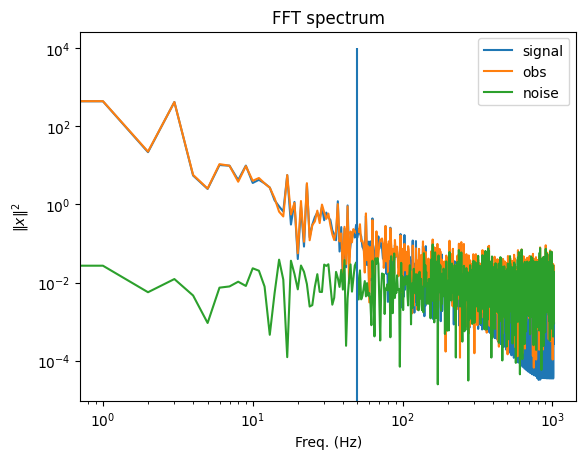

In [118]:
plot(freqs, np.abs(fft_signal)**2, label='signal')
plot(freqs, np.abs(fft_obs)**2, label='obs')
plot(freqs, np.abs(fft_noise)**2, label='noise')
yscale("log")
xscale("log")
xlabel("Freq. (Hz)")
ylabel(r"$\|x\|^2$")
title("FFT spectrum")
vlines(freqs[50],0,1e4)
legend();


In [119]:
sig_reco = irfft(fft_obs_cut,norm='forward')

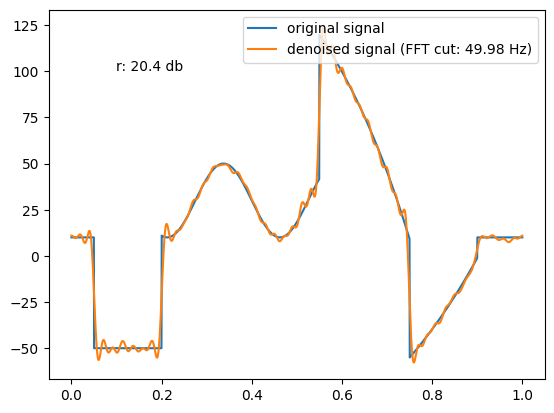

In [123]:
#plot(xvals,obs,label="noisy observation",alpha=0.5)
plot(xvals,signal,label="original signal")
plot(xvals,sig_reco, label=f"denoised signal (FFT cut: {freqs[n_cut]:.2f} Hz)")
legend()
text(0.1,100,f"r: {metric(sig_reco,signal):.3} db");